In [1]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj" -O openlogo.tar && rm -rf /tmp/cookies.txt
!tar -xvf openlogo.tar

images_folder = "openlogo/JPEGImages"
annotations_folder = "openlogo/Annotations"
train_query_file = "openlogo/ImageSets/Main/train_test/train_all.txt"
test_query_file = "openlogo/ImageSets/Main/train_test/test_all.txt"

Streaming output truncated to the last 5000 lines.
openlogo/JPEGImages/hondaimg000205.jpg
openlogo/Annotations/apeimg000015.xml
openlogo/Annotations/siemens3.xml
openlogo/JPEGImages/logos32plus_003856.jpg
openlogo/JPEGImages/chanel41.jpg
openlogo/JPEGImages/Belgalogos_07582934.jpg
openlogo/JPEGImages/61839900.jpg
openlogo/Annotations/kraftimg000003.xml
openlogo/JPEGImages/logos32plus_000801.jpg
openlogo/Annotations/logos32plus_003692.xml
openlogo/JPEGImages/essoimg000006.jpg
openlogo/JPEGImages/logos32plus_001952.jpg
openlogo/Annotations/batman5.xml
openlogo/JPEGImages/Hisense_sportslogo_65.jpg
openlogo/Annotations/logos32plus_000073.xml
openlogo/JPEGImages/flickrlogo27_3778060828.jpg
openlogo/Annotations/boschimg000151.xml
openlogo/JPEGImages/aralimg000145.jpg
openlogo/Annotations/prada48.xml
openlogo/JPEGImages/fritolaysimg000043.jpg
openlogo/Annotations/logos32plus_000459.xml
openlogo/Annotations/logos32plus_004264.xml
openlogo/JPEGImages/boeingimg000044.jpg
openlogo/JPEGImages/logo

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7995 (delta 1), reused 1 (delta 0), pack-reused 7993
Receiving objects: 100% (7995/7995), 10.12 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (5480/5480), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
image_pattern = re.compile(r'^(?P<key>\w+)\.jpg$')
annotation_pattern = re.compile(r'^(?P<key>\w+)\.xml$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, annotation_folder, query_file, transform=None, target_transform=None):
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.transform = transform
    self.target_transform = target_transform
    self.image_names = self.__get_file_names__(image_folder, image_pattern)
    self.annotation_names = self.__get_file_names__(annotation_folder, annotation_pattern)

    self.keys = sorted(list(set(self.image_names.keys()) & set(self.annotation_names.keys())))
    with open(query_file) as file:
      file_content = file.read()
      self.keys = list(filter(lambda key: key in file_content, self.keys))
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    key = self.keys[index]

    image_name = self.image_names[key]
    annotation_name = self.annotation_names[key]

    image_path = os.path.join(self.image_folder, image_name)
    annotation_path = os.path.join(self.annotation_folder, annotation_name)

    img = Image.open(image_path).convert('RGB')
    target = self.__get_target__(annotation_path, index)

    if self.transform:
      img = self.transform(img)

    if self.target_transform:
      img, target = self.target_transform(img, target)

    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img)  

    return img, target

  def __get_target__(self, annotation_path, index):
    target = {}
    boxes = []
    root = ET.parse(annotation_path).getroot()
    for bndbox in root.findall('object/bndbox'):
      xmin = int(bndbox[0].text)
      ymin = int(bndbox[1].text)
      xmax = int(bndbox[2].text)
      ymax = int(bndbox[3].text)
      boxes.append((xmin, ymin, xmax, ymax))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    return target

  def __get_file_names__(self, folder, file_name_pattern):
    file_names = {}
    for f in listdir(folder):
      match = file_name_pattern.match(f)
      if not match:
        continue
      
      num = match.group('key')
      if num == '':
        continue
      
      file_names[num] = f

    return file_names

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as detectionTransforms

trn = transforms.Compose([
                          transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                          transforms.RandomGrayscale(p=0.1)
])

target_trn = detectionTransforms.Compose([
                                detectionTransforms.ToTensor(),
])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=trn, target_transform=target_trn)
test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file, target_transform=target_trn)
orig_test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file)

validation_size = .3

data_size = len(dataset)
test_data_size = len(test_dataset)

split_val = int(np.floor(validation_size * data_size))

indices = list(range(data_size))
test_indices = list(range(test_data_size))
np.random.seed(42)
np.random.shuffle(indices)
np.random.shuffle(test_indices)
val_indices, train_indices = indices[:split_val], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          sampler=test_sampler, collate_fn=utils.collate_fn)

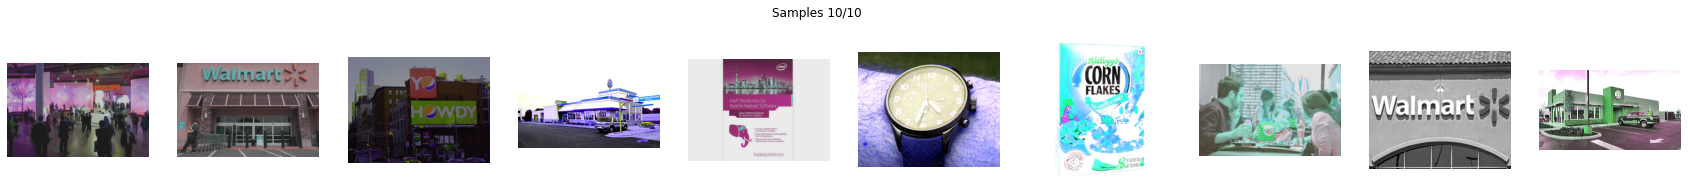

In [0]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        image, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')   
    
show_dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=transf.Compose([
                          transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                          transf.RandomGrayscale(p=0.1),   
]))
indices = np.random.choice(np.arange(len(show_dataset)), 10, replace=False)

visualize_samples(show_dataset, indices, "Samples")

In [0]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model.roi_heads.parameters(), lr=0.001, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [0]:
model = torch.load("drive/My Drive/save/save-aug-2")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

In [0]:
last_saved_epoch = 0
num_epochs = 1

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, last_saved_epoch + epoch, print_freq=1000)
  #lr_scheduler.step()
  #torch.save(model, "drive/My Drive/save/save-aug-" + str(last_saved_epoch + epoch))
  evaluate(model, val_loader, device=device)

torch.save(model, "drive/My Drive/save/save-adam-test-complete")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [   0/3244]  eta: 3:10:56  lr: 0.000002  loss: 1.4773 (1.4773)  loss_classifier: 0.5701 (0.5701)  loss_box_reg: 0.0632 (0.0632)  loss_objectness: 0.6902 (0.6902)  loss_rpn_box_reg: 0.1539 (0.1539)  time: 3.5316  data: 0.2975  max mem: 8256
Epoch: [0]  [1000/3244]  eta: 2:37:30  lr: 0.001000  loss: 0.3680 (0.4475)  loss_classifier: 0.0465 (0.0510)  loss_box_reg: 0.0212 (0.0193)  loss_objectness: 0.2569 (0.3340)  loss_rpn_box_reg: 0.0272 (0.0432)  time: 4.7840  data: 0.7193  max mem: 8528
Epoch: [0]  [2000/3244]  eta: 1:27:46  lr: 0.001000  loss: 0.3415 (0.4386)  loss_classifier: 0.0419 (0.0471)  loss_box_reg: 0.0175 (0.0193)  loss_objectness: 0.2647 (0.3297)  loss_rpn_box_reg: 0.0284 (0.0424)  time: 4.2739  data: 0.3636  max mem: 8567


In [0]:
model = torch.load("drive/My Drive/save/save-test-complete")
model.to(device)
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [   0/8322]  eta: 1:32:23  model_time: 0.6257 (0.6257)  evaluator_time: 0.0102 (0.0102)  time: 0.6661  data: 0.0223  max mem: 505
Test:  [ 100/8322]  eta: 0:23:16  model_time: 0.1454 (0.1476)  evaluator_time: 0.0029 (0.0032)  time: 0.1613  data: 0.0127  max mem: 616
Test:  [ 200/8322]  eta: 0:22:46  model_time: 0.1377 (0.1437)  evaluator_time: 0.0027 (0.0034)  time: 0.1649  data: 0.0214  max mem: 674
Test:  [ 300/8322]  eta: 0:22:11  model_time: 0.1381 (0.1422)  evaluator_time: 0.0032 (0.0034)  time: 0.1552  data: 0.0148  max mem: 674
Test:  [ 400/8322]  eta: 0:22:09  model_time: 0.1470 (0.1421)  evaluator_time: 0.0028 (0.0034)  time: 0.1623  data: 0.0139  max mem: 742
Test:  [ 500/8322]  eta: 0:21:42  model_time: 0.1461 (0.1418)  evaluator_time: 0.0027 (0.0033)  time: 0.1615  data: 0.0142  max mem: 742
Test:  [ 600/8322]  eta: 0:21:29  model_time: 0.1440 (0.1419)  evaluator_time: 0.0027 (0.0033)  time: 0.1596  data: 0.0141  max mem: 742
Test:  [

In [0]:
model = torch.load("drive/My Drive/save/save-aug-complete")

In [0]:
def get_iou(bb1, bb2):
  bb1_x1 = int(bb1[0])
  bb1_y1 = int(bb1[1])
  bb1_x2 = int(bb1[2])
  bb1_y2 = int(bb1[3])
  bb2_x1 = int(bb2[0])
  bb2_y1 = int(bb2[1])
  bb2_x2 = int(bb2[2])
  bb2_y2 = int(bb2[3])
  assert bb1_x1 < bb1_x2
  assert bb1_y1 < bb1_y2
  assert bb2_x1 < bb2_x2
  assert bb2_y1 < bb2_y2

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  display(str(x_left) + " " + str(y_top) + " " + str(x_right) + " " + str(y_bottom))

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

{'boxes': tensor([[489.8011, 173.8876, 734.0764, 291.7943],
         [675.3289, 169.8393, 747.0068, 243.4414],
         [778.5035, 282.5450, 931.6386, 331.1601],
         [480.7591, 380.1031, 534.4667, 418.0090],
         [416.2463, 353.7339, 468.6128, 381.7399],
         [546.9291, 376.7253, 628.2552, 409.6458],
         [680.6953, 187.3739, 741.1387, 229.1301],
         [546.2270, 178.6945, 691.8614, 273.6236],
         [  8.1845, 544.2183,  65.8427, 579.7234],
         [406.6155, 316.0320, 468.3064, 356.9637],
         [208.9552, 341.6104, 295.7968, 374.7431],
         [405.2072, 319.2324, 418.6398, 356.7569],
         [433.8416, 334.9209, 465.5418, 353.0794],
         [ 71.3044, 546.2068,  93.0275, 569.6149],
         [897.0412, 283.4723, 932.3311, 315.4810]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9888, 0.8603, 0.6581, 0.4792, 0.4172, 0.3942, 0.2769, 0.2169, 0.1701,


'675 173 734 243'

0.13717284442673044

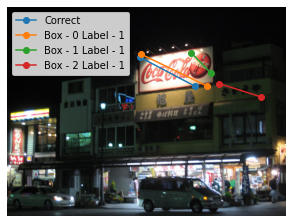

In [0]:
from PIL import ImageFilter

score_filter = 0.5

model.eval()
count = 1
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(test_loader):
  if i_step == count:
    break
    
  test_image = list(image.to(device) for image in images)
  prediction = model(test_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_test_dataset[image_id]

  boxes = target['boxes']
  display(prediction)
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']
  
  plt.subplot(1, count, i_step + 1)

  for box in boxes:
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    predict_label = int(predict_labels[i])
    view_label = 'Box - %d Label - %d' % (i, predict_label)
    plt.plot(x, y, marker = 'o', label=view_label)

  plt.imshow(image)

  plt.grid(False)
  plt.axis('off')
  plt.legend()  

{'boxes': tensor([[1017.9893, 1273.3477, 1117.0336, 1376.9805],
         [1016.5664, 1526.6970, 1082.3540, 1558.5846],
         [1048.1281, 1568.0979, 1129.8687, 1594.9951],
         [1010.5079, 1480.1183, 1146.4939, 1587.8136],
         [1014.6462, 1500.0035, 1088.3174, 1564.0809],
         [ 954.9126, 1262.5312, 1153.7952, 1386.3093],
         [1312.3260, 1266.4131, 1361.6360, 1352.9713],
         [1054.6182, 1420.9041, 1134.0876, 1495.6514],
         [ 793.5044, 1388.4470,  912.1085, 1629.0786]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9085, 0.1055, 0.0856, 0.0845, 0.0826, 0.0754, 0.0724, 0.0699, 0.0514],
        device='cuda:0', grad_fn=<IndexBackward>)}

{'boxes': tensor([[334.2732, 453.6880, 400.4834, 521.9833],
         [549.3461, 254.4227, 583.9625, 292.0977],
         [491.3891, 153.8172, 607.0971, 170.3027],
         [488.3213, 156.2312, 539.2694, 170.4860],
         [460.0149, 218.8388, 481.7401, 231.4944],
         [333.1145, 171.9471, 404.1729, 187.3956],
         [379.1163, 276.8338, 422.9518, 296.7804],
         [284.3394, 202.5788, 305.8049, 212.6516],
         [101.0925, 343.9393, 127.5929, 352.0998],
         [207.5457, 214.9468, 232.9935, 224.2556],
         [540.2841, 155.9722, 607.8274, 168.8782],
         [144.3217, 215.7102, 167.7858, 225.5587],
         [204.5590, 178.9900, 230.5648, 195.5809],
         [119.2415, 343.9517, 129.5247, 351.5525],
         [175.4410, 214.5548, 200.7931, 225.5741],
         [202.3925, 167.6854, 209.8286, 174.6976],
         [286.8770, 214.5985, 306.7330, 232.2288],
         [496.2849, 338.1772, 510.4920, 353.1971],
         [329.0037, 167.9250, 407.2023, 199.7936],
         [644.0589, 31

{'boxes': tensor([[552.3323,  55.6701, 614.1627, 117.1195],
         [195.9146, 377.5198, 276.4043, 461.0105],
         [125.3228, 447.7563, 347.1156, 533.1609],
         [ 61.0217, 187.4335, 395.3317, 234.6998],
         [492.1511,  94.6503, 674.3707, 178.9036],
         [173.5934, 654.6082, 297.7654, 786.2425],
         [193.6814, 515.9548, 265.5856, 589.0809],
         [303.7376, 572.3549, 364.4175, 609.4321],
         [195.8590, 674.1169, 275.3957, 775.9789],
         [474.7792,  47.9305, 693.9697, 197.6016],
         [123.8669, 380.3933, 349.1282, 568.0603]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9824, 0.9663, 0.9628, 0.8966, 0.8900, 0.8731, 0.3289, 0.2857, 0.0919,
         0.0649, 0.0614], device='cuda:0', grad_fn=<IndexBackward>)}

{'boxes': tensor([[1683.9296,  377.5618, 1990.0820,  597.1082],
         [ 162.0656,  605.7697,  420.6452,  675.3267],
         [2056.3486,  823.3981, 2140.9897,  880.4016],
         [2421.6064,  577.2991, 2654.2480,  642.3923],
         [2009.8901, 1435.7285, 2151.0554, 1603.5819],
         [1632.6609, 1053.9209, 1659.5206, 1083.1405],
         [2425.4260,  579.8200, 2465.5415,  637.8758],
         [1465.1705, 1064.7347, 1513.4436, 1089.3014],
         [1560.0469, 1061.8724, 1587.8148, 1078.1787],
         [ 163.0861,  605.1252,  203.5521,  660.6161],
         [1441.0065, 1054.7430, 1513.5095, 1096.8607],
         [1559.8434, 1065.5615, 1596.7360, 1083.2584],
         [2635.0488, 1348.2645, 2748.4392, 1501.9308],
         [1527.0303, 1068.4460, 1571.9824, 1084.2352],
         [1555.5421, 1102.8792, 1590.7896, 1120.5814],
         [1553.6591, 1066.3661, 1582.6625, 1082.5378],
         [1440.7466, 1061.7584, 1484.8518, 1090.3337],
         [2051.7009,  793.5627, 2151.5337,  892.6628],
 

{'boxes': tensor([[250.5943, 150.1310, 907.7407, 206.1567],
         [266.0348, 156.3280, 325.8812, 203.0743],
         [881.7099, 506.7347, 926.9268, 573.9606],
         [295.1986, 155.6270, 654.8813, 199.6788],
         [643.5892, 158.8912, 894.7154, 202.4705]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.7671, 0.2411, 0.1672, 0.1107, 0.0893], device='cuda:0',
        grad_fn=<IndexBackward>)}

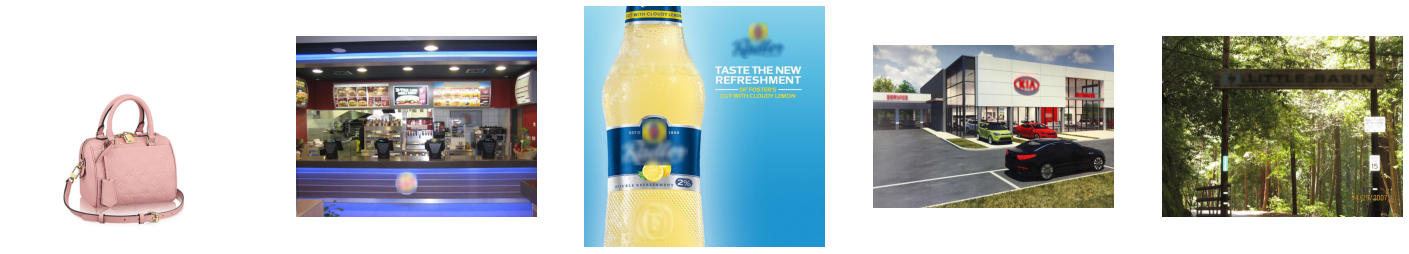

In [0]:
from PIL import ImageFilter

score_filter = 0.5

model.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(test_loader):
  if i_step == count:
    break
    
  test_image = list(image.to(device) for image in images)
  prediction = model(test_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_test_dataset[image_id]

  boxes = target['boxes']
  display(prediction)
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']

  plt.subplot(1, count, i_step + 1)

  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    ib = (int(box[0]), int(box[1]), int(box[2]), int(box[3]))
    ic = image.crop(ib)
    for i in range(20):
      ic = ic.filter(ImageFilter.GaussianBlur())
    image.paste(ic, ib)

  plt.imshow(image)

  plt.grid(False)
  plt.axis('off')